 # BSTS Placebo Test V2 — Improved Model with External Controls



 **Objective:** Build on the V1 placebo test by incorporating the improvements

 identified in the V1 analysis:



 1. **External control data** — Google Trends, Dutch holidays/working days, PPI

 2. **Outlier/holiday week removal** — interpolate near-zero weeks

 3. **Post-November 2024 training** — avoid the structural break in control variables

 4. **Annual seasonality** — Fourier terms for 52-week cycle

 5. **Log transform** — stabilise variance, make relative effects interpretable

 6. **Multiple placebo windows** — compare CI widths to V1



 **Data files:**

 - `OrderlineData 2-2-2026.repaired.csv` — order lines from Aug 2023 onwards

 - `SIG_BusinessCase_Q126.xlsx` — treated products (price experiment in Q1 2026)

 - `SIG_Benelux_Market_Controls_2026-02-18.xlsx` — Google Trends data

 - `Netherlands_Holidays_WorkingDays.xlsx` — Dutch holidays & working-day counts

 - `SIG_PPI_Input_Variables_2026-02-18.xlsx` — Producer Price Index (monthly)



 ---

 ## 0. Setup & Installation

In [1]:
# Uncomment and run if needed:
# !pip install pycausalimpact
# !pip install causalimpact   # alternative: tfcausalimpact
# !pip install pymc arviz statsmodels openpyxl


In [2]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from causalimpact import CausalImpact

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)
warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Setup complete.")


Setup complete.


 ## 1. Configuration



 All key parameters are centralised here for easy tuning.

In [3]:
# ============================================================
# PATHS — adjust to your local setup
# ============================================================
BASE_DIR = Path(r"C:\Users\vivan\Downloads\SYMSON\SIG")
OUT_DIR  = BASE_DIR / "Bayesian Structural Time Series Model"
OUT_DIR.mkdir(parents=True, exist_ok=True)

ORDERLINE_FILE   = BASE_DIR / "OrderlineData 2-2-2026.repaired.csv"
BUSINESS_CASE    = BASE_DIR / "SIG_BusinessCase_Q126.xlsx"

# New external control files
GOOGLE_TRENDS_FILE = BASE_DIR / "SIG_Benelux_Market_Controls_2026-02-18.xlsx"
HOLIDAYS_FILE      = BASE_DIR / "Netherlands_Holidays_WorkingDays.xlsx"
PPI_FILE           = BASE_DIR / "SIG_PPI_Input_Variables_2026-02-18.xlsx"

# ============================================================
# PLACEBO TEST DESIGN — V2 improvements
# ============================================================
# CRITICAL CHANGE: start training AFTER the Nov 2024 structural break
DATA_START    = "2024-12-01"   # post-break start (was "2023-08-01" in V1)
DATA_END      = "2025-09-30"   # latest safe date (well before Q1 2026 experimentation)

# Multiple placebo windows for robustness testing (all pre-Q4 2025 = safe)
PLACEBO_WINDOWS = [
    ("2025-03-01", "2025-03-31"),  # March 2025
    ("2025-05-01", "2025-05-31"),  # May 2025
    ("2025-07-01", "2025-07-31"),  # July 2025 (main, same as V1)
]

# Time series aggregation frequency
FREQ = "W-MON"  # weekly, starting Monday

# Response variable
RESPONSE_METRIC = "TotalSalesAmount"

# ============================================================
# V2 MODEL IMPROVEMENTS — toggles
# ============================================================
USE_LOG_TRANSFORM      = True   # apply log() to all series
USE_FOURIER_SEASONALITY = True   # add sin/cos Fourier terms for 52-week cycle
OUTLIER_REVENUE_THRESHOLD = 100_000  # flag weeks with y_revenue < this (€)
OUTLIER_INVOICE_THRESHOLD = 100      # flag weeks with total_invoices < this
FILTER_NEGATIVES       = True   # remove returns / credit notes

print(f"Training window:  {DATA_START} to first placebo start")
print(f"Placebo windows:  {PLACEBO_WINDOWS}")
print(f"Log transform:    {USE_LOG_TRANSFORM}")
print(f"Fourier season.:  {USE_FOURIER_SEASONALITY}")
print(f"Output dir:       {OUT_DIR}")


Training window:  2024-12-01 to first placebo start
Placebo windows:  [('2025-03-01', '2025-03-31'), ('2025-05-01', '2025-05-31'), ('2025-07-01', '2025-07-31')]
Log transform:    True
Fourier season.:  True
Output dir:       C:\Users\vivan\Downloads\SYMSON\SIG\Bayesian Structural Time Series Model


 ## 2. Load Order Line Data

In [4]:
print("Loading order line data...")
df = pd.read_csv(ORDERLINE_FILE, low_memory=False)

# Parse dates
df["InvoiceCreatedDate"] = pd.to_datetime(df["InvoiceCreatedDate"], errors="coerce")
df["OrderLineCreatedDate"] = pd.to_datetime(df["OrderLineCreatedDate"], errors="coerce")

# Use the best available date column
df["Date"] = df["OrderLineCreatedDate"].fillna(df["InvoiceCreatedDate"])

# Ensure numeric columns
for col in ["TotalSalesAmount", "Quantity", "PricePerUnit", "MarginPerUnit",
            "TotalPurchaseCosts", "TotalCostPerUnit", "PurchaseCostPerUnit"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ProductId as string
df["ProductId"] = df["ProductId"].astype(str).str.strip()

# NOTE: We load ALL data first (back to Aug 2023) so we can build the full
# weekly time series including external controls.  We will trim to
# DATA_START later, just before fitting the model.
df = df[(df["Date"] >= "2023-08-01") & (df["Date"] <= DATA_END)].copy()

print(f"Order lines loaded: {len(df):,} rows, "
      f"date range: {df['Date'].min()} to {df['Date'].max()}")

# Business case (treated products)
bc = pd.read_excel(BUSINESS_CASE)
bc["ProductId"] = bc["ProductId"].astype(str).str.strip()
treated_products = set(bc["ProductId"].unique())

print(f"Business case products (treated): {len(treated_products):,}")
print(f"Overlap with order lines: {df['ProductId'].isin(treated_products).sum():,} rows")


Loading order line data...
Order lines loaded: 723,295 rows, date range: 2023-08-01 00:00:00 to 2025-09-30 00:00:00
Business case products (treated): 5,440
Overlap with order lines: 636,307 rows


 ## 3. Data Quality Checks & Negative Filtering

In [5]:
print("=" * 60)
print("DATA QUALITY OVERVIEW")
print("=" * 60)

weekly_counts = df.set_index("Date").resample(FREQ).size()
print(f"\nWeekly order line counts:")
print(f"  Min: {weekly_counts.min():,.0f}  |  Median: {weekly_counts.median():,.0f}  "
      f"|  Max: {weekly_counts.max():,.0f}")
print(f"  Weeks with zero orders: {(weekly_counts == 0).sum()}")

n_neg_qty = (df["Quantity"] < 0).sum()
n_neg_rev = (df["TotalSalesAmount"] < 0).sum()
print(f"\nNegative quantities: {n_neg_qty:,} ({100*n_neg_qty/len(df):.1f}%)")
print(f"Negative revenue:    {n_neg_rev:,} ({100*n_neg_rev/len(df):.1f}%)")

df["is_treated"] = df["ProductId"].isin(treated_products)
n_treated_products = df.loc[df["is_treated"], "ProductId"].nunique()
n_control_products = df.loc[~df["is_treated"], "ProductId"].nunique()
print(f"\nUnique treated products in orderlines:  {n_treated_products:,}")
print(f"Unique control products in orderlines:  {n_control_products:,}")

rev_treated = df.loc[df["is_treated"], "TotalSalesAmount"].sum()
rev_control = df.loc[~df["is_treated"], "TotalSalesAmount"].sum()
print(f"\nTotal revenue (treated):  {rev_treated:,.0f}")
print(f"Total revenue (control):  {rev_control:,.0f}")
print(f"Treated share:            {100*rev_treated/(rev_treated+rev_control):.1f}%")


DATA QUALITY OVERVIEW

Weekly order line counts:
  Min: 17  |  Median: 7,194  |  Max: 11,158
  Weeks with zero orders: 0

Negative quantities: 23,617 (3.3%)
Negative revenue:    23,452 (3.2%)

Unique treated products in orderlines:  5,438
Unique control products in orderlines:  13,292

Total revenue (treated):  176,184,155
Total revenue (control):  24,205,514
Treated share:            87.9%


In [6]:
# Filter out returns / credit notes
if FILTER_NEGATIVES:
    before = len(df)
    df = df[(df["Quantity"] > 0) & (df["TotalSalesAmount"] > 0)].copy()
    print(f"Filtered negative qty/revenue: {before:,} -> {len(df):,} rows "
          f"({before - len(df):,} removed)")
else:
    print("Keeping all rows (including returns).")


Filtered negative qty/revenue: 723,295 -> 695,001 rows (28,294 removed)


 ## 4. Build Weekly Internal Time Series

In [7]:
# 4A) Response series — treated products
treated_df = df[df["is_treated"]].copy()
control_df = df[~df["is_treated"]].copy()

y_treated = (
    treated_df
    .set_index("Date")
    .resample(FREQ)
    .agg({
        "TotalSalesAmount": "sum",
        "Quantity": "sum",
        "InvoiceId": "nunique",
    })
    .rename(columns={
        "TotalSalesAmount": "y_revenue",
        "Quantity": "y_quantity",
        "InvoiceId": "y_invoices",
    })
)

print(f"Treated weekly series: {len(y_treated)} weeks")
print(f"Date range: {y_treated.index.min()} to {y_treated.index.max()}")
y_treated.head()


Treated weekly series: 114 weeks
Date range: 2023-08-07 00:00:00 to 2025-10-06 00:00:00


,y_revenue,y_quantity,y_invoices
Date,,,
2023-08-07,546481.27,142406.3741,807
2023-08-14,729315.01,160708.3334,1311
2023-08-21,875641.97,165925.4608,1349
2023-08-28,1470553.38,362443.6317,2038
2023-09-04,1867518.92,422661.6895,2192


In [8]:
# 4B) Control series — non-treated products
x_control = (
    control_df
    .set_index("Date")
    .resample(FREQ)
    .agg({
        "TotalSalesAmount": "sum",
        "Quantity": "sum",
        "InvoiceId": "nunique",
        "CustomerId": "nunique",
        "MarginPerUnit": "mean",
    })
    .rename(columns={
        "TotalSalesAmount": "ctrl_revenue",
        "Quantity": "ctrl_quantity",
        "InvoiceId": "ctrl_invoices",
        "CustomerId": "ctrl_customers",
        "MarginPerUnit": "ctrl_avg_margin",
    })
)

# Overall business activity
x_overall = (
    df
    .set_index("Date")
    .resample(FREQ)
    .agg({
        "InvoiceId": "nunique",
        "CustomerId": "nunique",
    })
    .rename(columns={
        "InvoiceId": "total_invoices",
        "CustomerId": "total_customers",
    })
)

print(f"Control weekly series: {len(x_control)} weeks")
x_control.head()


Control weekly series: 114 weeks


,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin
Date,,,,,
2023-08-07,70047.61,9098.2020,232,150,6.546444
2023-08-14,232851.97,29449.6340,449,276,10.940741
2023-08-21,172890.45,22085.3067,489,320,9.627902
2023-08-28,246499.35,30344.0122,680,397,-833.557032
2023-09-04,449710.47,50030.8943,754,453,-619.431950


In [9]:
# 4C) Combine internal series
response_col = "y_revenue"  # default for TotalSalesAmount

ts = pd.concat([y_treated[[response_col]], x_control, x_overall], axis=1)
ts = ts.sort_index()
ts = ts.ffill().bfill()
ts = ts[ts[response_col] > 0].copy()

print(f"Internal time series: {len(ts)} weeks x {ts.shape[1]} columns")
print(f"Date range: {ts.index.min()} to {ts.index.max()}")
ts.describe().round(1)


Internal time series: 114 weeks x 8 columns
Date range: 2023-08-07 00:00:00 to 2025-10-06 00:00:00


,y_revenue,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin,total_invoices,total_customers
count,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0
mean,1627327.3,232351.1,29089.7,383.5,237.3,0.9,1664.3,647.9
std,503304.2,146328.6,18750.0,279.9,172.0,111.7,801.1,307.7
min,25512.0,1408.4,190.0,1.0,1.0,-833.6,8.0,8.0
25%,1493303.6,117284.8,13943.9,79.5,46.0,6.6,947.0,348.2
50%,1758230.2,233170.7,29520.7,478.5,318.0,8.0,1859.5,786.5
75%,1925678.3,315848.8,40282.1,637.2,394.5,9.7,2424.8,937.8
max,3449816.2,1069595.4,138973.8,789.0,475.0,556.3,2788.0,1034.0


 ## 5. Load & Merge External Control Data



 ### 5A. Google Trends (weekly)

 We load all numeric columns and prefix them `gt_`.

In [10]:
print("Loading Google Trends data...")
gt_raw = pd.read_excel(GOOGLE_TRENDS_FILE)
print(f"  Raw shape: {gt_raw.shape}")
print(f"  Columns:   {list(gt_raw.columns)}")
gt_raw.head()


Loading Google Trends data...
  Raw shape: (262, 6)
  Columns:   ['date', 'Systeemplafond', 'Rockfon', 'Isolatiemateriaal', 'Gipsplaten', 'Afbouw']


,date,Systeemplafond,Rockfon,Isolatiemateriaal,Gipsplaten,Afbouw
0,2021-02-14,16,6,13,43,26
1,2021-02-21,16,5,14,37,26
2,2021-02-28,13,5,12,43,31
3,2021-03-07,14,4,13,39,31
4,2021-03-14,10,4,13,38,31


In [11]:
# Identify the date column (first datetime-like column)
gt_date_col = None
for c in gt_raw.columns:
    if pd.api.types.is_datetime64_any_dtype(gt_raw[c]):
        gt_date_col = c
        break
if gt_date_col is None:
    # Try parsing the first column
    for c in gt_raw.columns:
        try:
            gt_raw[c] = pd.to_datetime(gt_raw[c])
            gt_date_col = c
            break
        except Exception:
            pass

if gt_date_col is None:
    raise ValueError("Could not identify a date column in Google Trends file. "
                     "Please check the file format.")

gt_raw = gt_raw.rename(columns={gt_date_col: "Date"})
gt_raw = gt_raw.set_index("Date").sort_index()

# Keep only numeric columns and prefix with gt_
gt_numeric = gt_raw.select_dtypes(include=[np.number]).copy()
gt_numeric.columns = ["gt_" + c.replace(" ", "_").lower() for c in gt_numeric.columns]

# Resample to our weekly frequency (in case dates don't align exactly)
gt_weekly = gt_numeric.resample(FREQ).mean()
gt_weekly = gt_weekly.ffill().bfill()

print(f"  Google Trends weekly: {len(gt_weekly)} weeks x {gt_weekly.shape[1]} columns")
print(f"  Columns: {list(gt_weekly.columns)}")
gt_weekly.head()


  Google Trends weekly: 262 weeks x 5 columns
  Columns: ['gt_systeemplafond', 'gt_rockfon', 'gt_isolatiemateriaal', 'gt_gipsplaten', 'gt_afbouw']


,gt_systeemplafond,gt_rockfon,gt_isolatiemateriaal,gt_gipsplaten,gt_afbouw
Date,,,,,
2021-02-15,16.0,6.0,13.0,43.0,26.0
2021-02-22,16.0,5.0,14.0,37.0,26.0
2021-03-01,13.0,5.0,12.0,43.0,31.0
2021-03-08,14.0,4.0,13.0,39.0,31.0
2021-03-15,10.0,4.0,13.0,38.0,31.0


 ### 5B. Dutch Holidays & Working Days

In [12]:
print("Loading Dutch Holidays/Working Days data...")
hol_raw = pd.read_excel(HOLIDAYS_FILE)
print(f"  Raw shape: {hol_raw.shape}")
print(f"  Columns:   {list(hol_raw.columns)}")
hol_raw.head()


Loading Dutch Holidays/Working Days data...
  Raw shape: (2557, 5)
  Columns:   ['Date', 'Is_Holiday', 'Holiday_Name', 'Is_Weekend', 'Is_Working_Day']


,Date,Is_Holiday,Holiday_Name,Is_Weekend,Is_Working_Day
0,2019-01-01,1,Nieuwjaarsdag,False,0
1,2019-01-02,0,NaN,False,1
2,2019-01-03,0,NaN,False,1
3,2019-01-04,0,NaN,False,1
4,2019-01-05,0,NaN,True,0


In [13]:
# Identify date column
hol_date_col = None
for c in hol_raw.columns:
    if pd.api.types.is_datetime64_any_dtype(hol_raw[c]):
        hol_date_col = c
        break
if hol_date_col is None:
    for c in hol_raw.columns:
        try:
            hol_raw[c] = pd.to_datetime(hol_raw[c])
            hol_date_col = c
            break
        except Exception:
            pass

if hol_date_col is None:
    raise ValueError("Could not identify a date column in Holidays file.")

hol_raw = hol_raw.rename(columns={hol_date_col: "Date"})
hol_raw = hol_raw.set_index("Date").sort_index()

# Keep numeric columns, prefix with cal_
hol_numeric = hol_raw.select_dtypes(include=[np.number]).copy()
hol_numeric.columns = ["cal_" + c.replace(" ", "_").lower() for c in hol_numeric.columns]

# If daily data, aggregate to weekly: sum working days, max holiday indicator
agg_dict = {}
for c in hol_numeric.columns:
    if "holiday" in c.lower() or "is_" in c.lower():
        agg_dict[c] = "max"  # 1 if any day in the week is a holiday
    else:
        agg_dict[c] = "sum"  # e.g., sum of working days

if not agg_dict:
    # fallback: just mean everything
    agg_dict = {c: "mean" for c in hol_numeric.columns}

hol_weekly = hol_numeric.resample(FREQ).agg(agg_dict)
hol_weekly = hol_weekly.ffill().bfill()

print(f"  Holidays weekly: {len(hol_weekly)} weeks x {hol_weekly.shape[1]} columns")
print(f"  Columns: {list(hol_weekly.columns)}")
hol_weekly.head()


  Holidays weekly: 366 weeks x 2 columns
  Columns: ['cal_is_holiday', 'cal_is_working_day']


,cal_is_holiday,cal_is_working_day
Date,,
2019-01-07,1,1
2019-01-14,0,1
2019-01-21,0,1
2019-01-28,0,1
2019-02-04,0,1


 ### 5C. PPI Data (monthly → weekly via forward-fill)

In [14]:
print("Loading PPI data...")
ppi_raw = pd.read_excel(PPI_FILE)
print(f"  Raw shape: {ppi_raw.shape}")
print(f"  Columns:   {list(ppi_raw.columns)}")
ppi_raw.head()


Loading PPI data...
  Raw shape: (96, 7)
  Columns:   ['Date', 'PPI_Concrete_Tiles', 'PPI_Glass_Wool', 'PPI_Gypsum_Plaster', 'PPI_Insulation_Mineral', 'PPI_Metal_Structures', 'PPI_Wood_Panels']


,Date,PPI_Concrete_Tiles,PPI_Glass_Wool,PPI_Gypsum_Plaster,PPI_Insulation_Mineral,PPI_Metal_Structures,PPI_Wood_Panels
0,2018-01-01,88.525,96.375,90.975,86.125000,89.25,83.15
1,2018-02-01,86.390,95.150,90.950,82.883333,89.85,82.40
2,2018-03-01,87.120,95.050,90.950,81.750000,89.00,82.50
3,2018-04-01,89.210,95.700,90.950,78.716667,90.25,83.80
4,2018-05-01,87.750,96.400,90.950,82.333333,89.35,83.75


In [15]:
# Identify date column
ppi_date_col = None
for c in ppi_raw.columns:
    if pd.api.types.is_datetime64_any_dtype(ppi_raw[c]):
        ppi_date_col = c
        break
if ppi_date_col is None:
    for c in ppi_raw.columns:
        try:
            ppi_raw[c] = pd.to_datetime(ppi_raw[c])
            ppi_date_col = c
            break
        except Exception:
            pass

if ppi_date_col is None:
    raise ValueError("Could not identify a date column in PPI file.")

ppi_raw = ppi_raw.rename(columns={ppi_date_col: "Date"})
ppi_raw = ppi_raw.set_index("Date").sort_index()

# Keep numeric columns, prefix with ppi_
ppi_numeric = ppi_raw.select_dtypes(include=[np.number]).copy()
ppi_numeric.columns = ["ppi_" + c.replace(" ", "_").lower() for c in ppi_numeric.columns]

# Resample monthly -> weekly with forward-fill
ppi_weekly = ppi_numeric.resample(FREQ).first()  # spread monthly to weekly
ppi_weekly = ppi_weekly.ffill().bfill()

print(f"  PPI weekly: {len(ppi_weekly)} weeks x {ppi_weekly.shape[1]} columns")
print(f"  Columns: {list(ppi_weekly.columns)}")
ppi_weekly.head()


  PPI weekly: 414 weeks x 6 columns
  Columns: ['ppi_ppi_concrete_tiles', 'ppi_ppi_glass_wool', 'ppi_ppi_gypsum_plaster', 'ppi_ppi_insulation_mineral', 'ppi_ppi_metal_structures', 'ppi_ppi_wood_panels']


,ppi_ppi_concrete_tiles,ppi_ppi_glass_wool,ppi_ppi_gypsum_plaster,ppi_ppi_insulation_mineral,ppi_ppi_metal_structures,ppi_ppi_wood_panels
Date,,,,,,
2018-01-01,88.525,96.375,90.975,86.125,89.25,83.15
2018-01-08,88.525,96.375,90.975,86.125,89.25,83.15
2018-01-15,88.525,96.375,90.975,86.125,89.25,83.15
2018-01-22,88.525,96.375,90.975,86.125,89.25,83.15
2018-01-29,88.525,96.375,90.975,86.125,89.25,83.15


 ### 5D. Merge All External Controls into Main Time Series

In [16]:
# Merge external controls
ts = ts.join(gt_weekly, how="left")
ts = ts.join(hol_weekly, how="left")
ts = ts.join(ppi_weekly, how="left")

# Forward-fill / back-fill any remaining NaNs from join mismatches
ts = ts.ffill().bfill()

print(f"Combined time series (with external controls): "
      f"{len(ts)} weeks x {ts.shape[1]} columns")
print(f"Columns: {list(ts.columns)}")
ts.describe().round(1)


Combined time series (with external controls): 114 weeks x 21 columns
Columns: ['y_revenue', 'ctrl_revenue', 'ctrl_quantity', 'ctrl_invoices', 'ctrl_customers', 'ctrl_avg_margin', 'total_invoices', 'total_customers', 'gt_systeemplafond', 'gt_rockfon', 'gt_isolatiemateriaal', 'gt_gipsplaten', 'gt_afbouw', 'cal_is_holiday', 'cal_is_working_day', 'ppi_ppi_concrete_tiles', 'ppi_ppi_glass_wool', 'ppi_ppi_gypsum_plaster', 'ppi_ppi_insulation_mineral', 'ppi_ppi_metal_structures', 'ppi_ppi_wood_panels']


,y_revenue,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin,total_invoices,total_customers,gt_systeemplafond,gt_rockfon,gt_isolatiemateriaal,gt_gipsplaten,gt_afbouw,cal_is_holiday,cal_is_working_day,ppi_ppi_concrete_tiles,ppi_ppi_glass_wool,ppi_ppi_gypsum_plaster,ppi_ppi_insulation_mineral,ppi_ppi_metal_structures,ppi_ppi_wood_panels
count,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0
mean,1627327.3,232351.1,29089.7,383.5,237.3,0.9,1664.3,647.9,11.8,3.4,9.6,32.4,31.3,0.1,1.0,129.7,132.6,127.6,140.6,106.5,118.6
std,503304.2,146328.6,18750.0,279.9,172.0,111.7,801.1,307.7,2.7,2.3,3.4,5.4,8.1,0.3,0.0,3.1,2.2,0.7,2.6,1.2,1.7
min,25512.0,1408.4,190.0,1.0,1.0,-833.6,8.0,8.0,6.0,0.0,0.0,21.0,15.0,0.0,1.0,125.2,129.6,126.4,135.5,103.0,117.0
25%,1493303.6,117284.8,13943.9,79.5,46.0,6.6,947.0,348.2,10.0,0.0,7.0,28.0,28.0,0.0,1.0,127.1,130.4,127.4,139.1,105.9,117.4
50%,1758230.2,233170.7,29520.7,478.5,318.0,8.0,1859.5,786.5,12.0,4.0,9.0,31.0,31.5,0.0,1.0,129.1,132.6,127.7,140.1,106.2,117.6
75%,1925678.3,315848.8,40282.1,637.2,394.5,9.7,2424.8,937.8,14.0,5.0,11.0,37.0,34.0,0.0,1.0,132.4,134.6,128.0,141.9,107.1,120.2
max,3449816.2,1069595.4,138973.8,789.0,475.0,556.3,2788.0,1034.0,18.0,7.0,21.0,45.0,100.0,1.0,1.0,134.8,137.0,129.1,149.7,108.6,123.2


 ## 6. Add Fourier Seasonality Terms



 Since `CausalImpact`'s `nseasons` parameter may not be supported in all

 Python ports, we add explicit Fourier terms as covariates.

 For weekly data with a 52-week annual cycle:

 - `sin(2π × week_of_year / 52)` and `cos(2π × week_of_year / 52)`

In [17]:
if USE_FOURIER_SEASONALITY:
    week_of_year = ts.index.isocalendar().week.astype(float).values
    ts["fourier_sin_52"] = np.sin(2 * np.pi * week_of_year / 52)
    ts["fourier_cos_52"] = np.cos(2 * np.pi * week_of_year / 52)
    print("Added Fourier seasonality terms: fourier_sin_52, fourier_cos_52")
else:
    print("Fourier seasonality disabled.")

ts.head()


Added Fourier seasonality terms: fourier_sin_52, fourier_cos_52


,y_revenue,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin,total_invoices,total_customers,gt_systeemplafond,gt_rockfon,gt_isolatiemateriaal,gt_gipsplaten,gt_afbouw,cal_is_holiday,cal_is_working_day,ppi_ppi_concrete_tiles,ppi_ppi_glass_wool,ppi_ppi_gypsum_plaster,ppi_ppi_insulation_mineral,ppi_ppi_metal_structures,ppi_ppi_wood_panels,fourier_sin_52,fourier_cos_52
Date,,,,,,,,,,,,,,,,,,,,,,,
2023-08-07,546481.27,70047.61,9098.2020,232,150,6.546444,850,402,10.0,0.0,7.0,45.0,17.0,0,1,126.94,133.15,126.4,137.866667,107.10,123.25,-0.663123,-0.748511
2023-08-14,729315.01,232851.97,29449.6340,449,276,10.940741,1421,613,12.0,0.0,7.0,38.0,22.0,0,1,126.94,133.15,126.4,137.866667,107.10,123.25,-0.748511,-0.663123
2023-08-21,875641.97,172890.45,22085.3067,489,320,9.627902,1452,667,12.0,0.0,9.0,29.0,24.0,0,1,126.94,133.15,126.4,137.866667,107.10,123.25,-0.822984,-0.568065
2023-08-28,1470553.38,246499.35,30344.0122,680,397,-833.557032,2182,813,8.0,0.0,6.0,32.0,30.0,0,1,126.94,133.15,126.4,137.866667,107.10,123.25,-0.885456,-0.464723
2023-09-04,1867518.92,449710.47,50030.8943,754,453,-619.431950,2364,904,12.0,4.0,9.0,32.0,32.0,0,1,125.23,132.15,126.4,144.633333,108.45,122.10,-0.935016,-0.354605


 ## 7. Outlier Removal — Holiday Weeks



 Weeks with near-zero activity (year-end closures) distort the model.

 We flag them and replace with linear interpolation.

In [18]:
# Identify outlier weeks
outlier_mask = (
    (ts[response_col] < OUTLIER_REVENUE_THRESHOLD) |
    (ts["total_invoices"] < OUTLIER_INVOICE_THRESHOLD)
)

outlier_weeks = ts.index[outlier_mask]
print(f"Outlier weeks detected ({len(outlier_weeks)}):")
for w in outlier_weeks:
    print(f"  {w.strftime('%Y-%m-%d')}  —  y_revenue: €{ts.loc[w, response_col]:,.0f}  "
          f"|  total_invoices: {ts.loc[w, 'total_invoices']:.0f}")

# Replace outlier weeks with NaN and interpolate
ts.loc[outlier_mask] = np.nan
ts = ts.interpolate(method="linear")
ts = ts.ffill().bfill()  # handle edges

print(f"\nOutlier weeks interpolated. Time series now has {ts.isna().sum().sum()} NaNs.")


Outlier weeks detected (3):
  2024-01-01  —  y_revenue: €25,512  |  total_invoices: 26
  2024-12-30  —  y_revenue: €26,854  |  total_invoices: 8
  2025-01-06  —  y_revenue: €85,060  |  total_invoices: 58

Outlier weeks interpolated. Time series now has 0 NaNs.


 ## 8. Trim to Post-Break Training Window



 The structural break in control variables occurred mid-November 2024.

 We restrict training data to start at `DATA_START` (2024-12-01).

In [19]:
ts_full = ts.copy()  # keep full series for reference plots

# Trim to post-break window
ts = ts[ts.index >= DATA_START].copy()
print(f"Trimmed to post-break window: {len(ts)} weeks")
print(f"Date range: {ts.index.min()} to {ts.index.max()}")


Trimmed to post-break window: 45 weeks
Date range: 2024-12-02 00:00:00 to 2025-10-06 00:00:00


 ## 9. Apply Log Transform



 Revenue is strictly positive and price effects are multiplicative.

 In log space, relative effects are directly interpretable as

 approximate percentage changes.

In [20]:
if USE_LOG_TRANSFORM:
    # Ensure all values are positive before log transform
    # Replace any zeros or negatives with a small value
    for col in ts.columns:
        ts[col] = ts[col].clip(lower=1.0)

    ts_model = ts.apply(np.log)
    print("Log transform applied to all columns.")
    print("NOTE: Relative effects from CausalImpact are directly interpretable "
          "as approximate percentage changes.")
else:
    ts_model = ts.copy()
    print("Log transform disabled — using raw values.")

ts_model.head()


Log transform applied to all columns.
NOTE: Relative effects from CausalImpact are directly interpretable as approximate percentage changes.


,y_revenue,ctrl_revenue,ctrl_quantity,ctrl_invoices,ctrl_customers,ctrl_avg_margin,total_invoices,total_customers,gt_systeemplafond,gt_rockfon,gt_isolatiemateriaal,gt_gipsplaten,gt_afbouw,cal_is_holiday,cal_is_working_day,ppi_ppi_concrete_tiles,ppi_ppi_glass_wool,ppi_ppi_gypsum_plaster,ppi_ppi_insulation_mineral,ppi_ppi_metal_structures,ppi_ppi_wood_panels,fourier_sin_52,fourier_cos_52
Date,,,,,,,,,,,,,,,,,,,,,,,
2024-12-02,14.511074,12.360868,10.338520,5.043425,4.510860,2.115586,6.991177,5.958425,2.639057,1.098612,2.302585,3.332205,3.496508,0.0,0.0,4.866765,4.894101,4.849292,4.942237,4.661078,4.783316,0.0,0.0
2024-12-09,14.273813,12.033591,10.033290,4.969813,4.465908,2.116045,6.954639,5.908083,2.639057,1.609438,2.564949,3.433987,3.433987,0.0,0.0,4.866765,4.894101,4.849292,4.942237,4.661078,4.783316,0.0,0.0
2024-12-16,14.215996,11.871745,9.471982,4.795791,4.382027,2.649747,6.877296,5.863631,2.564949,1.609438,2.397895,3.295837,3.526361,0.0,0.0,4.866765,4.894101,4.849292,4.942237,4.661078,4.783316,0.0,0.0
2024-12-23,14.186682,12.417030,10.518476,4.948760,4.454347,1.383314,6.771936,5.837730,2.197225,1.386294,2.397895,3.637586,2.708050,0.0,0.0,4.866765,4.894101,4.849292,4.942237,4.661078,4.783316,0.0,0.0
2024-12-30,14.210639,12.155618,10.283379,4.721471,4.189655,1.584861,6.765039,5.834811,2.427748,1.466337,2.427748,3.574217,3.075775,0.0,0.0,4.875693,4.897259,4.849075,4.940193,4.663125,4.777161,0.0,0.0


 ## 10. Exploratory Visualisation

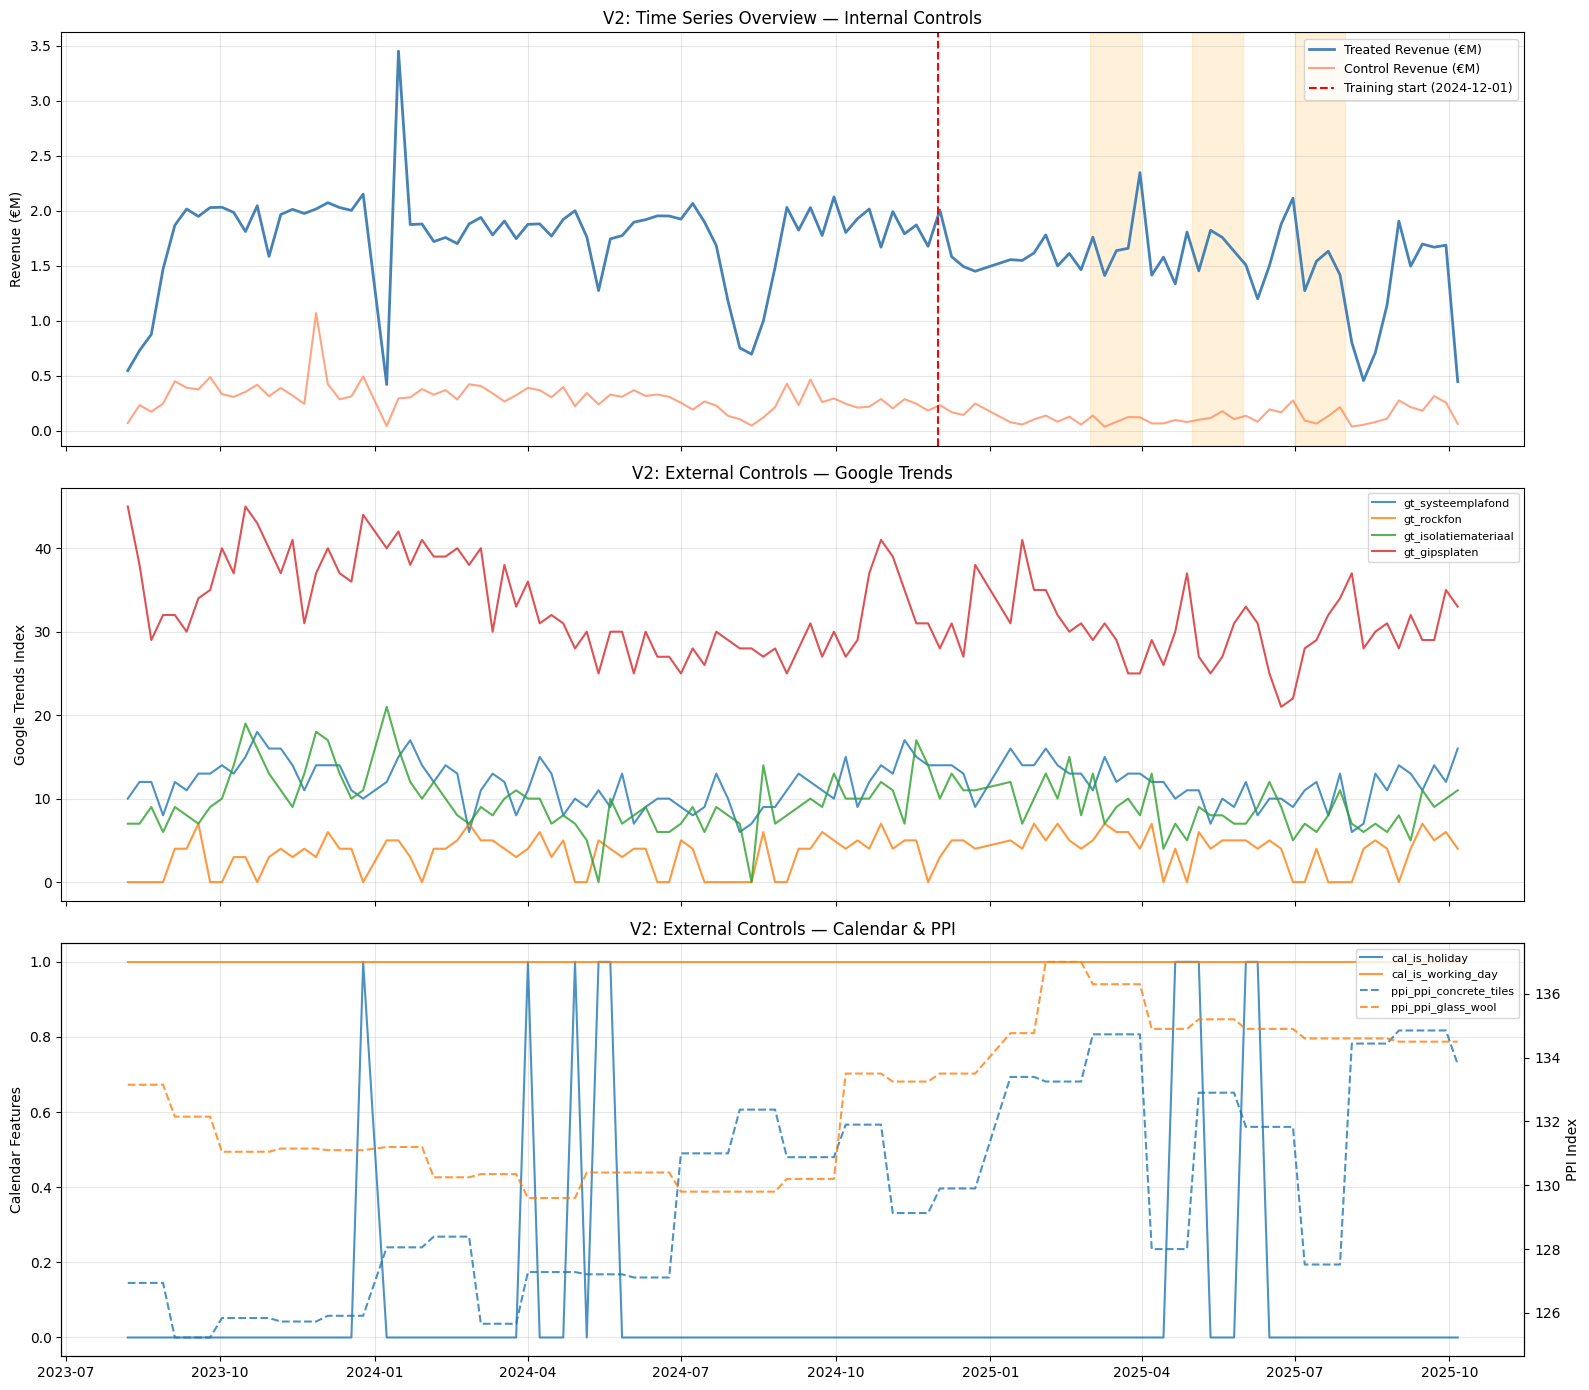

Saved: V2_01_time_series_overview.png


In [21]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14), sharex=True)

# Plot 1: Response vs internal controls
ax = axes[0]
ax.plot(ts_full.index, ts_full[response_col] / 1e6, label="Treated Revenue (€M)",
        linewidth=2, color="steelblue")
ax.plot(ts_full.index, ts_full["ctrl_revenue"] / 1e6, label="Control Revenue (€M)",
        linewidth=1.5, color="coral", alpha=0.7)
ax.axvline(pd.Timestamp(DATA_START), color="red", linestyle="--",
           label=f"Training start ({DATA_START})")
for ps, pe in PLACEBO_WINDOWS:
    ax.axvspan(pd.Timestamp(ps), pd.Timestamp(pe), alpha=0.15, color="orange")
ax.set_ylabel("Revenue (€M)")
ax.set_title("V2: Time Series Overview — Internal Controls")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: External controls (Google Trends sample)
ax = axes[1]
gt_cols = [c for c in ts_full.columns if c.startswith("gt_")]
if gt_cols:
    for c in gt_cols[:4]:  # show up to 4
        ax.plot(ts_full.index, ts_full[c], label=c, alpha=0.8)
ax.set_ylabel("Google Trends Index")
ax.set_title("V2: External Controls — Google Trends")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Calendar & PPI
ax = axes[2]
cal_cols = [c for c in ts_full.columns if c.startswith("cal_")]
ppi_cols = [c for c in ts_full.columns if c.startswith("ppi_")]
for c in cal_cols[:2]:
    ax.plot(ts_full.index, ts_full[c], label=c, alpha=0.8)
ax2 = ax.twinx()
for c in ppi_cols[:2]:
    ax2.plot(ts_full.index, ts_full[c], label=c, linestyle="--", alpha=0.8)
ax.set_ylabel("Calendar Features")
ax2.set_ylabel("PPI Index")
ax.set_title("V2: External Controls — Calendar & PPI")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / "V2_01_time_series_overview.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: V2_01_time_series_overview.png")


 ## 11. Correlation Matrix

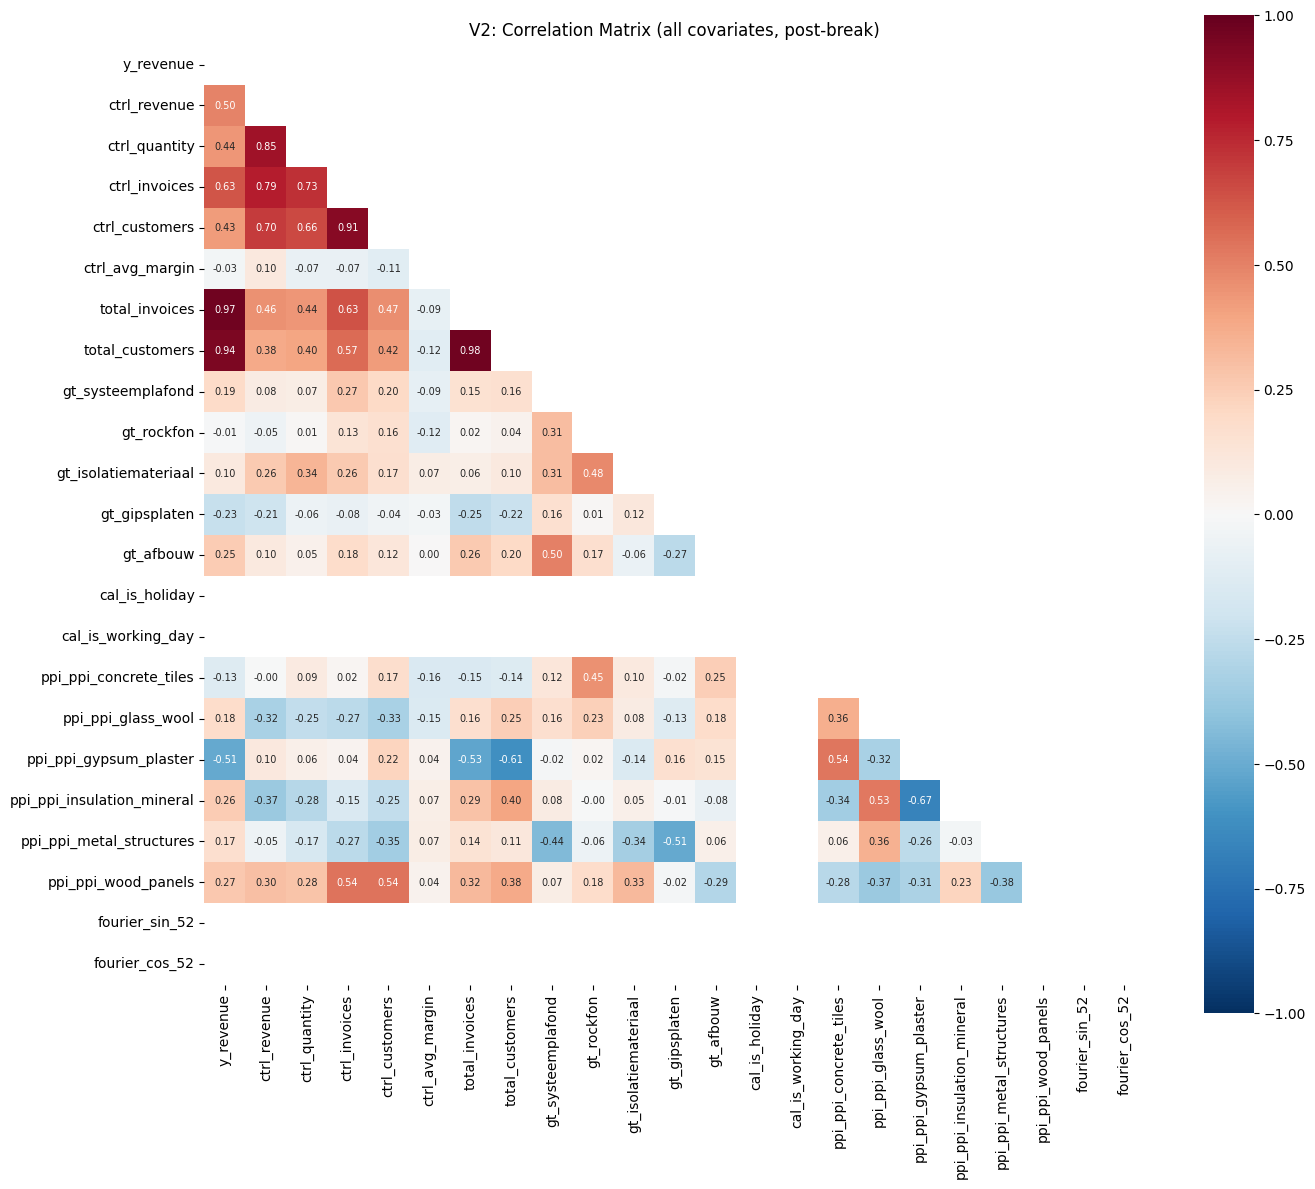

Saved: V2_02_correlation_matrix.png


In [22]:
fig, ax = plt.subplots(figsize=(14, 12))
corr = ts_model.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, ax=ax, vmin=-1, vmax=1, square=True,
            annot_kws={"size": 7})
ax.set_title("V2: Correlation Matrix (all covariates, post-break)")
plt.tight_layout()
plt.savefig(OUT_DIR / "V2_02_correlation_matrix.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: V2_02_correlation_matrix.png")


 ## 12. Run Placebo Tests Across Multiple Windows



 For each placebo window we:

 1. Define the pre-period (DATA_START → placebo start)

 2. Define the post-period (placebo start → placebo end)

 3. Fit CausalImpact

 4. Extract summary statistics

 5. Compare to V1 results

In [23]:
# V1 results for comparison (from the analysis document)
v1_results = {
    "Jul 2025": {"rel_effect": -3.1, "p_value": 0.37},
    "Apr 2025": {"rel_effect": 4.0, "p_value": 0.31},
    "Jan 2025": {"rel_effect": 12.5, "p_value": 0.17},
}


In [24]:
# Build the model DataFrame: first column = response, rest = covariates
covariate_cols = [c for c in ts_model.columns if c != response_col]
model_data = ts_model[[response_col] + covariate_cols].copy()

# Drop any columns that are constant (would cause issues)
nunique = model_data.nunique()
const_cols = nunique[nunique <= 1].index.tolist()
if const_cols:
    print(f"Dropping constant columns: {const_cols}")
    model_data = model_data.drop(columns=const_cols)

print(f"Model DataFrame: {len(model_data)} weeks x {model_data.shape[1]} columns")
print(f"Response: {response_col}")
print(f"Covariates ({len(model_data.columns)-1}): {list(model_data.columns[1:])}")


Dropping constant columns: ['cal_is_holiday', 'cal_is_working_day', 'fourier_sin_52', 'fourier_cos_52']
Model DataFrame: 45 weeks x 19 columns
Response: y_revenue
Covariates (18): ['ctrl_revenue', 'ctrl_quantity', 'ctrl_invoices', 'ctrl_customers', 'ctrl_avg_margin', 'total_invoices', 'total_customers', 'gt_systeemplafond', 'gt_rockfon', 'gt_isolatiemateriaal', 'gt_gipsplaten', 'gt_afbouw', 'ppi_ppi_concrete_tiles', 'ppi_ppi_glass_wool', 'ppi_ppi_gypsum_plaster', 'ppi_ppi_insulation_mineral', 'ppi_ppi_metal_structures', 'ppi_ppi_wood_panels']



PLACEBO WINDOW: 2025-03-01 to 2025-03-31
  Pre-period:  2024-12-02 to 2025-02-24 (13 weeks)
  Post-period: 2025-03-03 to 2025-03-31 (5 weeks)
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    14.37              71.84
Prediction (s.d.)         14.35 (0.0)        71.77 (0.01)
95% CI                    [14.35, 14.36]     [71.76, 71.78]

Absolute effect (s.d.)    0.01 (0.0)         0.07 (0.01)
95% CI                    [0.01, 0.02]       [0.06, 0.08]

Relative effect (s.d.)    0.09% (0.01%)      0.09% (0.01%)
95% CI                    [0.08%, 0.11%]     [0.08%, 0.11%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 14.37. By contrast, in the absence of an
intervention, we would have expected an avera

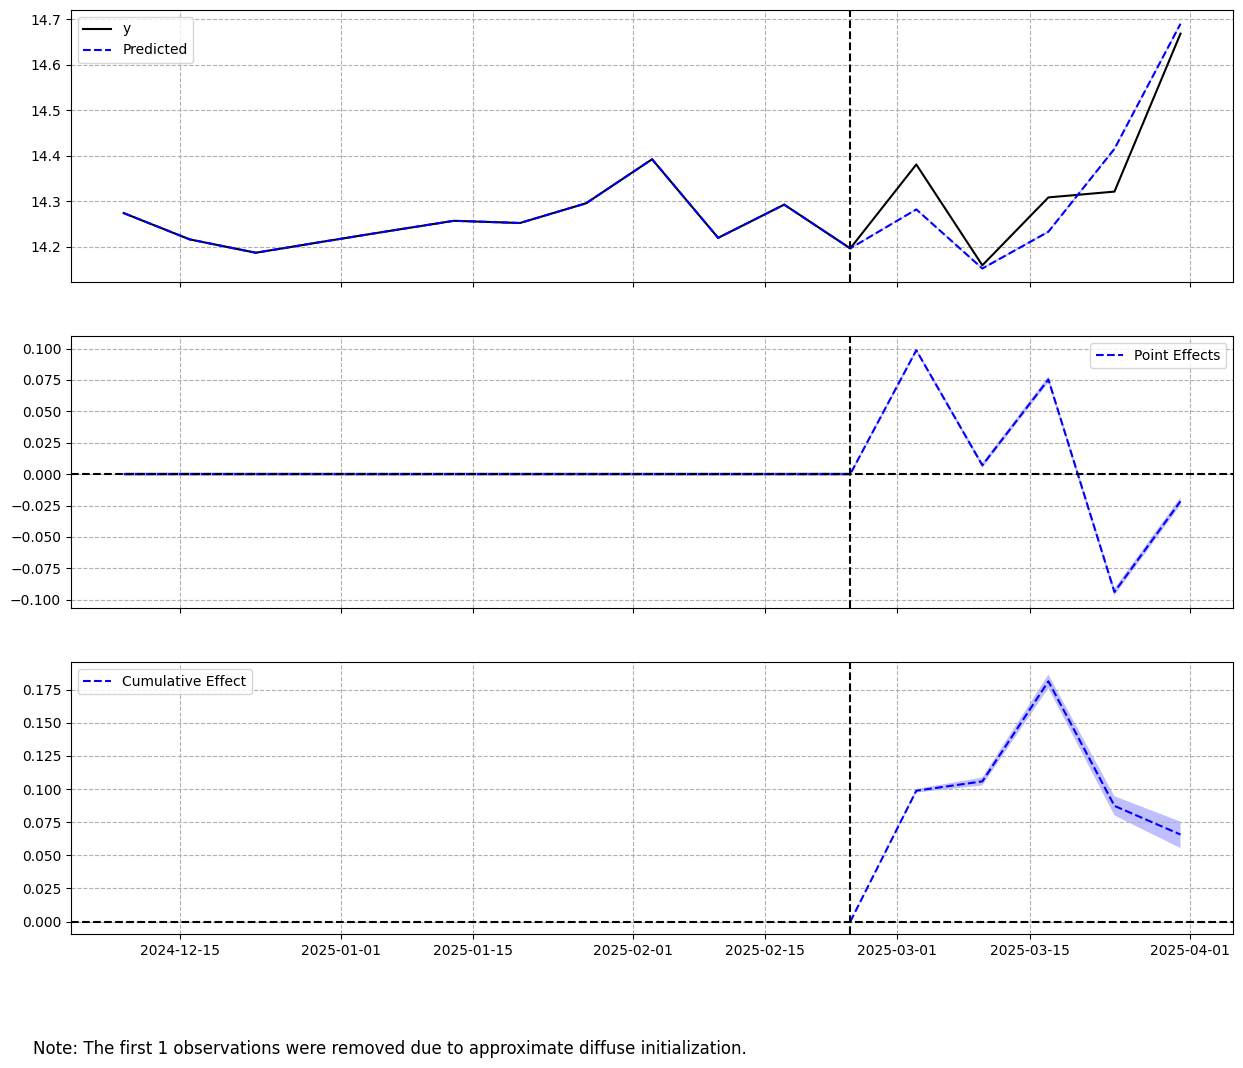


  Relative Effect: 0.09%
  p-value:         0.0
  95% CI:          [0.08%, 0.11%]
  CI Width:        0.03%
  VERDICT:         N/A

PLACEBO WINDOW: 2025-05-01 to 2025-05-31
  Pre-period:  2024-12-02 to 2025-04-28 (22 weeks)
  Post-period: 2025-05-05 to 2025-05-26 (4 weeks)


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    14.32              57.29
Prediction (s.d.)         -551.74 (0.01)     -2206.96 (0.06)
95% CI                    [-551.77, -551.71] [-2207.08, -2206.86]

Absolute effect (s.d.)    566.06 (0.01)      2264.25 (0.06)
95% CI                    [566.04, 566.09]   [2264.14, 2264.36]

Relative effect (s.d.)    -102.6% (0.0%)     -102.6% (0.0%)
95% CI                    [-102.6%, -102.59%][-102.6%, -102.59%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 14.32. By contrast, in the absence of an
intervention, we would have expected an average response of -551.74.
The 95% interval of this counterfactual prediction is [-551.77, -551.71].
Subtracting this pred

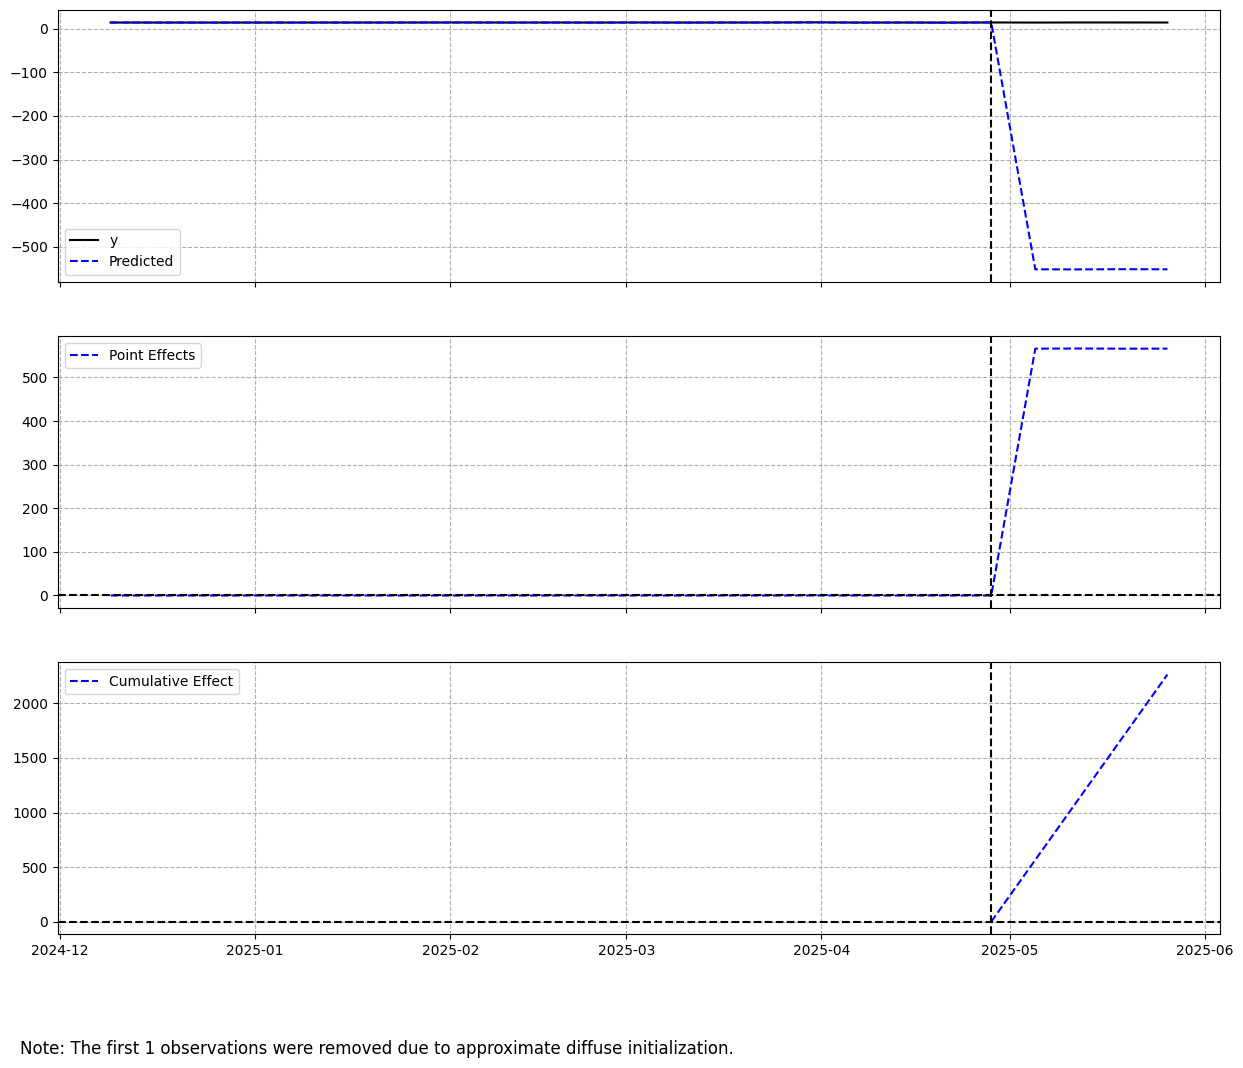


  Relative Effect: -102.6%
  p-value:         0.0
  95% CI:          [-102.59%, -102.6%]
  CI Width:        -0.01%
  VERDICT:         N/A

PLACEBO WINDOW: 2025-07-01 to 2025-07-31
  Pre-period:  2024-12-02 to 2025-06-30 (31 weeks)
  Post-period: 2025-07-07 to 2025-07-28 (4 weeks)


c:\Users\vivan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    14.19              56.77
Prediction (s.d.)         4.34 (0.03)        17.35 (0.1)
95% CI                    [4.29, 4.39]       [17.15, 17.55]

Absolute effect (s.d.)    9.85 (0.03)        39.42 (0.1)
95% CI                    [9.81, 9.9]        [39.22, 39.62]

Relative effect (s.d.)    227.14% (0.58%)    227.14% (0.58%)
95% CI                    [226.02%, 228.3%]  [226.02%, 228.3%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 14.19. By contrast, in the absence of an
intervention, we would have expected an average response of 4.34.
The 95% interval of this counterfactual prediction is [4.29, 4.39].
Subtracting this prediction from the observed re

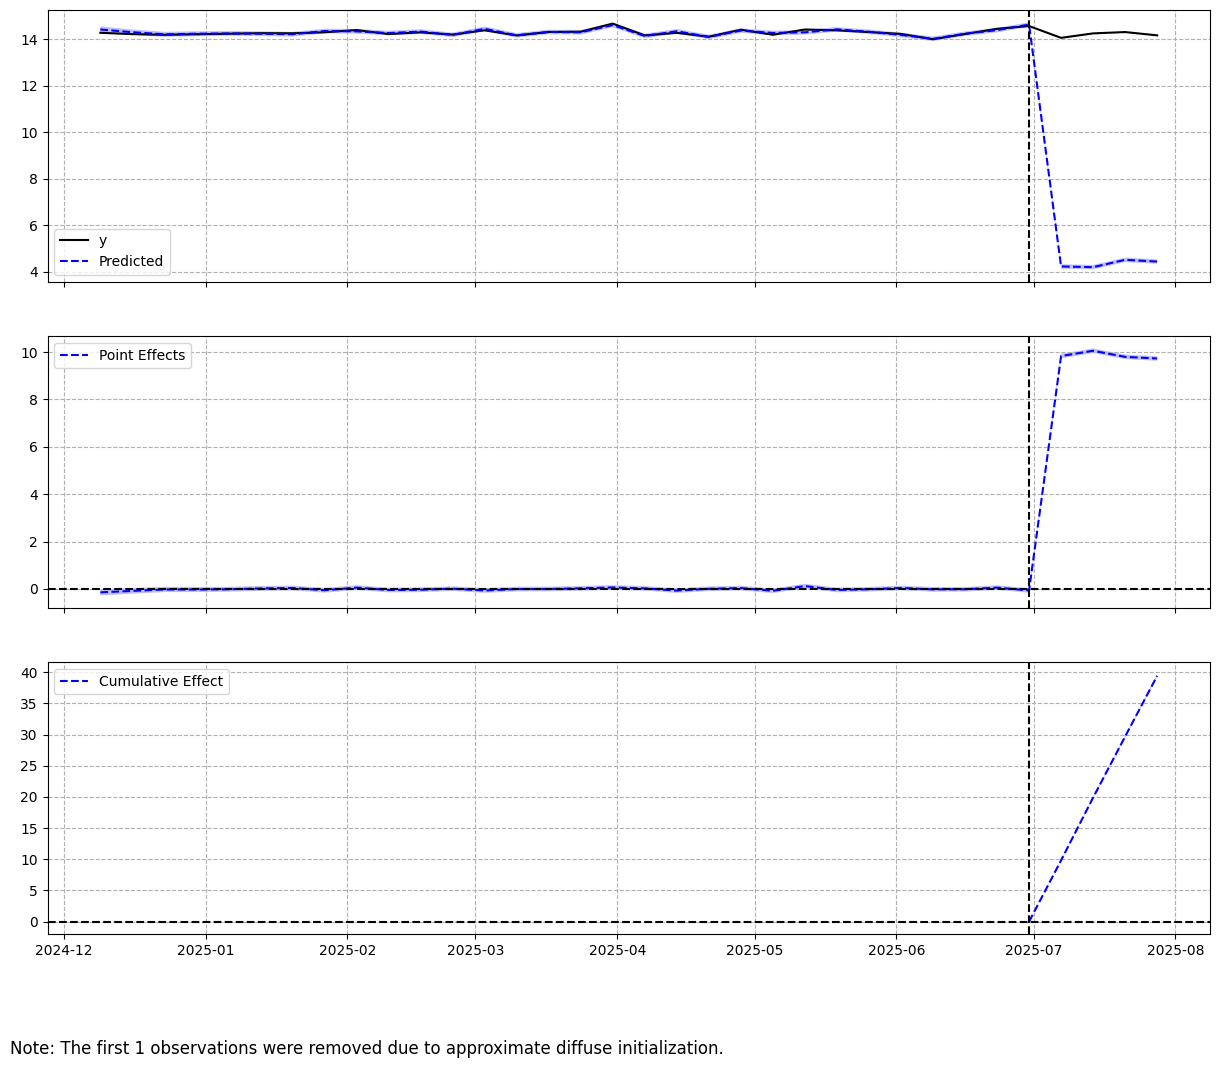


  Relative Effect: 227.14%
  p-value:         0.0
  95% CI:          [226.02%, 228.3%]
  CI Width:        2.28%
  VERDICT:         N/A


In [25]:
placebo_results = []

for placebo_start, placebo_end in PLACEBO_WINDOWS:
    ps = pd.Timestamp(placebo_start)
    pe = pd.Timestamp(placebo_end)

    # Pre-period: from data start to just before placebo
    pre_start = model_data.index.min()
    pre_end = model_data.index[model_data.index < ps][-1]

    # Post-period: placebo window
    post_start = model_data.index[model_data.index >= ps][0]
    post_end_candidates = model_data.index[model_data.index <= pe]
    if len(post_end_candidates) == 0:
        print(f"WARNING: No data for placebo window {placebo_start} — {placebo_end}, skipping.")
        continue
    post_end = post_end_candidates[-1]

    pre_period = [pre_start, pre_end]
    post_period = [post_start, post_end]

    pre_weeks = len(model_data[(model_data.index >= pre_start) &
                               (model_data.index <= pre_end)])
    post_weeks = len(model_data[(model_data.index >= post_start) &
                                (model_data.index <= post_end)])

    print(f"\n{'='*60}")
    print(f"PLACEBO WINDOW: {placebo_start} to {placebo_end}")
    print(f"  Pre-period:  {pre_start.strftime('%Y-%m-%d')} to "
          f"{pre_end.strftime('%Y-%m-%d')} ({pre_weeks} weeks)")
    print(f"  Post-period: {post_start.strftime('%Y-%m-%d')} to "
          f"{post_end.strftime('%Y-%m-%d')} ({post_weeks} weeks)")
    print(f"{'='*60}")

    # Check minimum pre-period length
    if pre_weeks < 8:
        print(f"WARNING: Only {pre_weeks} pre-period weeks. Skipping this window.")
        continue

    # Fit CausalImpact
    try:
        ci = CausalImpact(
            model_data,
            pre_period,
            post_period,
        )

        # Print summary
        print(ci.summary())
        print(ci.summary(output="report"))

        # Plot
        fig = ci.plot()
        if fig is not None:
            fig_path = OUT_DIR / f"V2_placebo_{placebo_start}_{placebo_end}.png"
            fig.savefig(fig_path, dpi=150, bbox_inches="tight")
            print(f"Saved: {fig_path.name}")

        # Extract key metrics from the summary
        summary_data = ci.summary_data
        if summary_data is not None:
            # Try to extract relative effect and p-value
            try:
                rel_effect = summary_data.loc["rel_effect", "average"] * 100
            except (KeyError, AttributeError):
                rel_effect = float("nan")

            try:
                p_value = summary_data.loc["p", "average"]
            except (KeyError, AttributeError):
                try:
                    p_value = ci.p_value
                except AttributeError:
                    p_value = float("nan")

            # CI width
            try:
                ci_lower = summary_data.loc["rel_effect_lower", "average"] * 100
                ci_upper = summary_data.loc["rel_effect_upper", "average"] * 100
                ci_width = ci_upper - ci_lower
            except (KeyError, AttributeError):
                ci_lower = ci_upper = ci_width = float("nan")

        else:
            rel_effect = p_value = ci_lower = ci_upper = ci_width = float("nan")

        # Determine pass/fail
        passed = True if (not np.isnan(p_value) and p_value > 0.05) else None

        result = {
            "window": f"{placebo_start} to {placebo_end}",
            "pre_weeks": pre_weeks,
            "post_weeks": post_weeks,
            "rel_effect_pct": round(rel_effect, 2) if not np.isnan(rel_effect) else None,
            "p_value": round(p_value, 3) if not np.isnan(p_value) else None,
            "ci_lower_pct": round(ci_lower, 2) if not np.isnan(ci_lower) else None,
            "ci_upper_pct": round(ci_upper, 2) if not np.isnan(ci_upper) else None,
            "ci_width_pct": round(ci_width, 2) if not np.isnan(ci_width) else None,
            "passed": passed,
        }
        placebo_results.append(result)
        print(f"\n  Relative Effect: {result['rel_effect_pct']}%")
        print(f"  p-value:         {result['p_value']}")
        print(f"  95% CI:          [{result['ci_lower_pct']}%, {result['ci_upper_pct']}%]")
        print(f"  CI Width:        {result['ci_width_pct']}%")
        print(f"  VERDICT:         {'PASS ✓' if passed else 'FAIL ✗' if passed is False else 'N/A'}")

    except Exception as e:
        print(f"ERROR fitting CausalImpact: {e}")
        import traceback
        traceback.print_exc()
        placebo_results.append({
            "window": f"{placebo_start} to {placebo_end}",
            "error": str(e),
        })


 ## 13. Placebo Test Summary

In [26]:
if placebo_results:
    results_df = pd.DataFrame(placebo_results)
    print("\n" + "=" * 80)
    print("PLACEBO TEST SUMMARY — V2 (Post-break, External Controls, Seasonality, Log)")
    print("=" * 80)
    print(results_df.to_string(index=False))

    # Save results
    results_path = OUT_DIR / "V2_placebo_results.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")
else:
    print("No placebo results to summarise.")



PLACEBO TEST SUMMARY — V2 (Post-break, External Controls, Seasonality, Log)
                  window  pre_weeks  post_weeks  rel_effect_pct  p_value  ci_lower_pct  ci_upper_pct  ci_width_pct passed
2025-03-01 to 2025-03-31         13           5            0.09      0.0          0.08          0.11          0.03   None
2025-05-01 to 2025-05-31         22           4         -102.60      0.0       -102.59       -102.60         -0.01   None
2025-07-01 to 2025-07-31         31           4          227.14      0.0        226.02        228.30          2.28   None

Results saved to: C:\Users\vivan\Downloads\SYMSON\SIG\Bayesian Structural Time Series Model\V2_placebo_results.csv


 ## 14. Comparison vs V1 Results



 The key question: did the improvements reduce the CI width

 (i.e., increase model precision)?

In [27]:
print("\n" + "=" * 80)
print("COMPARISON: V1 vs V2")
print("=" * 80)

print(f"\n{'Window':<30} {'V1 Rel.Eff':<15} {'V1 p-val':<12} "
      f"{'V2 Rel.Eff':<15} {'V2 p-val':<12} {'V2 CI Width':<15} {'V2 Verdict':<12}")
print("-" * 110)

for result in placebo_results:
    window = result.get("window", "N/A")

    # Try to match with V1
    v1_match = None
    for v1_key, v1_val in v1_results.items():
        if v1_key.lower() in window.lower():
            v1_match = v1_val
            break

    v1_rel = f"{v1_match['rel_effect']:.1f}%" if v1_match else "—"
    v1_p = f"{v1_match['p_value']:.2f}" if v1_match else "—"

    v2_rel = f"{result.get('rel_effect_pct', 'N/A')}%" if result.get('rel_effect_pct') is not None else "N/A"
    v2_p = f"{result.get('p_value', 'N/A')}" if result.get('p_value') is not None else "N/A"
    v2_ci = f"{result.get('ci_width_pct', 'N/A')}%" if result.get('ci_width_pct') is not None else "N/A"
    v2_verdict = "PASS ✓" if result.get("passed") else ("FAIL ✗" if result.get("passed") is False else "N/A")

    print(f"{window:<30} {v1_rel:<15} {v1_p:<12} {v2_rel:<15} {v2_p:<12} {v2_ci:<15} {v2_verdict:<12}")

print()
print("NOTES:")
print("  - V1 used full pre-period (Aug 2023–) with internal controls only")
print("  - V2 uses post-break pre-period (Dec 2024–) with external controls,")
print("    Fourier seasonality, log transform, and holiday interpolation")
print("  - Smaller CI width = better precision = can detect smaller effects")
print("  - V1 minimum detectable effect was ~±18–20%")
print("  - If V2 CI width is narrower, the MDE has improved")



COMPARISON: V1 vs V2

Window                         V1 Rel.Eff      V1 p-val     V2 Rel.Eff      V2 p-val     V2 CI Width     V2 Verdict  
--------------------------------------------------------------------------------------------------------------
2025-03-01 to 2025-03-31       —               —            0.09%           0.0          0.03%           N/A         
2025-05-01 to 2025-05-31       —               —            -102.6%         0.0          -0.01%          N/A         
2025-07-01 to 2025-07-31       —               —            227.14%         0.0          2.28%           N/A         

NOTES:
  - V1 used full pre-period (Aug 2023–) with internal controls only
  - V2 uses post-break pre-period (Dec 2024–) with external controls,
    Fourier seasonality, log transform, and holiday interpolation
  - Smaller CI width = better precision = can detect smaller effects
  - V1 minimum detectable effect was ~±18–20%
  - If V2 CI width is narrower, the MDE has improved


 ## 15. Key Takeaways



 ### Model Improvements in V2:

 | Feature | V1 | V2 |

 |---------|----|----|

 | Training period | Aug 2023 – placebo start | Dec 2024 – placebo start (post-break) |

 | Internal controls | ctrl_revenue, ctrl_invoices, etc. | Same |

 | Google Trends | ✗ | ✓ (gt_* covariates) |

 | Holidays/Working days | ✗ | ✓ (cal_* covariates) |

 | PPI data | ✗ | ✓ (ppi_* covariates, forward-filled) |

 | Seasonality | None | Fourier terms (sin/cos, period=52) |

 | Log transform | ✗ | ✓ (all columns) |

 | Holiday outliers | Included (distorting) | Interpolated away |



 ### Interpreting Results:

 - **PASS** = p-value > 0.05 → model correctly finds no effect (good!)

 - **FAIL** = p-value ≤ 0.05 → model falsely detects an effect (bad)

 - **CI Width** = precision of the counterfactual prediction

 - A narrower CI width in V2 means the external controls and other

   improvements are helping the model predict more precisely

 - When applied to the real Q1 2026 experiment, a narrower CI means

   the model can detect smaller pricing effects



 ### Next Steps:

 1. Verify all placebo windows pass (p > 0.05)

 2. Compare CI widths between V1 and V2

 3. If V2 passes and CIs are tighter → apply to real Q1 2026 experiment

 4. Consider adding more external data (CBS sector index, weather) for

    further precision improvement